In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
from scipy import stats

#**데이터셋 로드, 전처리**

In [96]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/seoul_final.csv',
                     encoding = 'UTF-8')
data = data[data['add'] == '서울']
rain = data[['date', 'sum_rn']]
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3957 entries, 0 to 3956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3957 non-null   object 
 1   sum_rn  3957 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.7+ KB


            sum_rn
date              
2012-01-01     0.0
2012-01-02     0.0
2012-01-03     0.0
2012-01-04     0.0
2012-01-05     0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


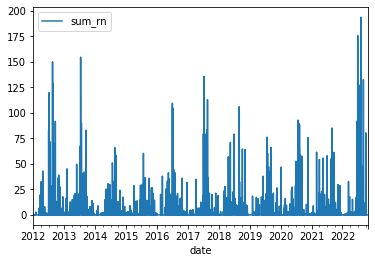

In [97]:
rain['date'] = pd.to_datetime(rain['date'])
rain = rain.set_index('date')
print(rain.head())
rain.plot()

In [98]:
log_rain = np.log(rain+1) - np.mean(np.log(rain+1))

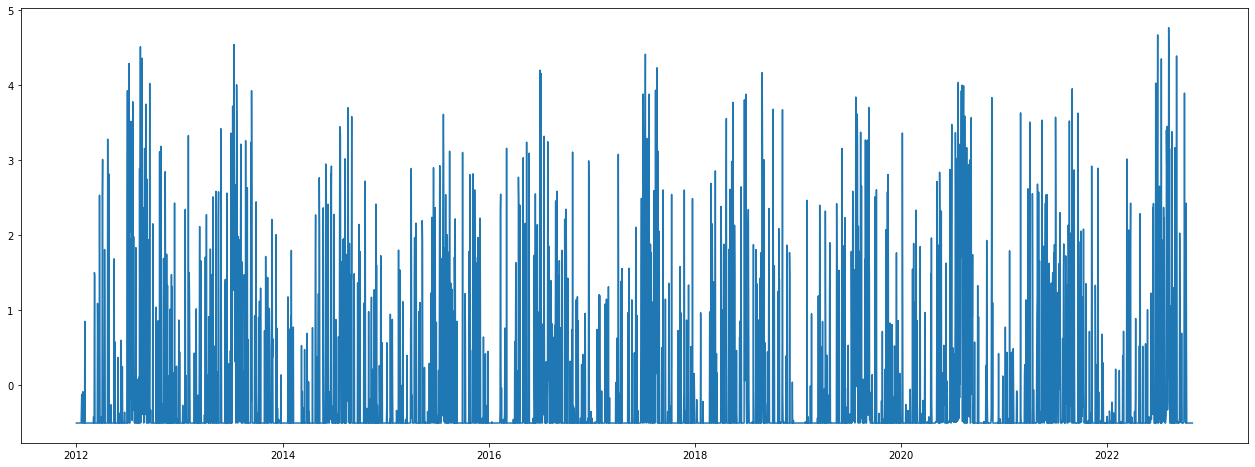

In [99]:
plt.figure(figsize=(22,8))
plt.plot(log_rain)
plt.show()

###**raw data**

In [100]:
#train test split
split_date = pd.Timestamp('2021-12-31')
#split_date2 = pd.Timestamp('2019-12-31')

train = rain.loc[:split_date,['sum_rn']]
#train = rain.loc[split_date2: ,['sum_rn']]
test = rain.loc[split_date:,['sum_rn']]
print(train.shape, test.shape)

(3653, 1) (305, 1)


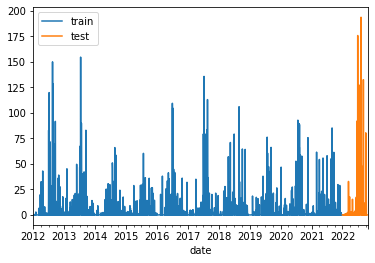

In [101]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [102]:
# 변수 scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

train_sc

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       ...,
       [4.45921785e-05],
       [0.00000000e+00],
       [0.00000000e+00]])

In [103]:
#다시 dataframe으로 변환
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
date,
2012-01-01,0.0
2012-01-02,0.0
2012-01-03,0.0
2012-01-04,0.0
2012-01-05,0.0


In [104]:
#window 생성
#window size = time stamp = 20 20개 관측해서 현재값 예측
window_size = 20
for s in range(1, window_size+1):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

train_sc_df.head(window_size+1)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20
date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,0.000000,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-07,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-08,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
#NA 제거, train test 저장
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [106]:
#다시 array로 변환
X_train = X_train.values
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)

(3633, 20)
[[3.00997193e-03 1.67220663e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.45921767e-04 3.00997193e-03 1.67220663e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.45921767e-04 3.00997193e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.22960892e-04 0.00000000e+00]
 [4.45921785e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.22960892e-04]
 [0.00000000e+00 4.45921785e-05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(3633, 1)
[[4.45921767e-04]
 [0.00000000e+00]
 [0.00000000e+00]
 ...
 [4.45921785e-05]
 [0.00000000e+00]
 [0.00000000e+00]]


In [107]:
#LSTM 구조로 만들어주기 (size, time, feature)
X_train_t = X_train.reshape(X_train.shape[0], window_size, 1)
X_test_t = X_test.reshape(X_test.shape[0], window_size, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(3633, 20, 1)
[[[3.00997193e-03]
  [1.67220663e-03]
  [0.00000000e+00]
  ...
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[4.45921767e-04]
  [3.00997193e-03]
  [1.67220663e-03]
  ...
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [4.45921767e-04]
  [3.00997193e-03]
  ...
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 ...

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  ...
  [0.00000000e+00]
  [2.22960892e-04]
  [0.00000000e+00]]

 [[4.45921785e-05]
  [0.00000000e+00]
  [0.00000000e+00]
  ...
  [0.00000000e+00]
  [0.00000000e+00]
  [2.22960892e-04]]

 [[0.00000000e+00]
  [4.45921785e-05]
  [0.00000000e+00]
  ...
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]]
[[4.45921767e-04]
 [0.00000000e+00]
 [0.00000000e+00]
 ...
 [4.45921785e-05]
 [0.00000000e+00]
 [0.00000000e+00]]


In [108]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras import optimizers

K.clear_session()
model = Sequential()

'''
model.add(LSTM(64, return_sequences=True, activation = 'relu',
               input_shape=(window_size,1))) # (timestep, feature)
model.add(LSTM(64, return_sequences=True, activation = 'relu',
               input_shape=(window_size,1)))
               '''
model.add(LSTM(20, return_sequences=True, input_shape=(window_size,1)))
model.add(LSTM(20, return_sequences=False, input_shape=(window_size,1)))

model.add(Dropout(0.01))

model.add(Dense(1)) # output = 1

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 20)            1760      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [109]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = model.fit(X_train_t, y_train, epochs=500, shuffle = False,
          validation_data=(X_test, y_test),
          batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/500
364/364 [==============================] - 50s 18ms/step - loss: 0.0056
Epoch 2/500
364/364 [==============================] - 6s 18ms/step - loss: 0.0054
Epoch 3/500
364/364 [==============================] - 7s 18ms/step - loss: 0.0054
Epoch 4/500
364/364 [==============================] - 6s 17ms/step - loss: 0.0053
Epoch 5/500
364/364 [==============================] - 6s 18ms/step - loss: 0.0053
Epoch 6/500
364/364 [==============================] - 7s 19ms/step - loss: 0.0053
Epoch 7/500
364/364 [==============================] - 7s 18ms/step - loss: 0.0053
Epoch 8/500
364/364 [==============================] - 6s 17ms/step - loss: 0.0053
Epoch 9/500
364/364 [==============================] - 7s 18ms/step - loss: 0.0053
Epoch 10/500
364/364 [==============================] - 7s 18ms/step - loss: 0.0053
Epoch 11/500
364/364 [==============================] - 7s 18ms/step - loss: 0.0053
Epoch 12/500
364/364 [==============================] - 7s 18ms/step - loss: 0.0052


In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [110]:
train_pred = model.predict(X_train_t)
test_pred = model.predict(X_test_t)

# invert predictions
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform(y_train)
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test)

9/9 [==============================] - 0s 5ms/step


In [111]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
r_trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('rmse Train Score: %.2f RMSE' % (r_trainScore))
r_testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('rmse Test Score: %.2f RMSE' % (r_testScore))
m_train_Score = mean_absolute_error(y_train, train_pred)
print('mae Train Score: %.2f MAE' % (m_train_Score))
m_test_Score = mean_absolute_error(y_test, test_pred)
print('mae Test Score: %.2f MAE' % (m_test_Score))

rmse Train Score: 13.94 RMSE
rmse Test Score: 22.07 RMSE
mae Train Score: 5.92 MAE
mae Test Score: 8.47 MAE


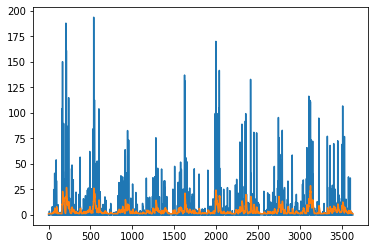

In [112]:
plt.plot(y_train)
plt.plot(train_pred)

###**log 취해**

In [114]:
#train test split
split_date = pd.Timestamp('2021-12-31')
#split_date2 = pd.Timestamp('2019-12-31')

log_train = log_rain.loc[:split_date,['sum_rn']]
#train = rain.loc[split_date2: ,['sum_rn']]
log_test = log_rain.loc[split_date:,['sum_rn']]
print(log_train.shape, log_test.shape)

(3653, 1) (305, 1)


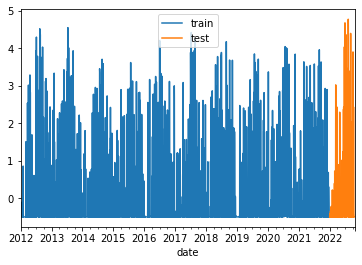

In [115]:
ax = log_train.plot()
log_test.plot(ax=ax)
plt.legend(['train', 'test'])

In [ ]:
# 변수 scaling
scaler = MinMaxScaler(feature_range=(0, 1))
log_train_sc = scaler.fit_transform(log_train)
log_test_sc = scaler.fit_transform(log_test)

log_train_sc

In [ ]:
#다시 dataframe으로 변환
log_train_sc_df = pd.DataFrame(log_train_sc, columns=['Scaled'], index=log_train.index)
log_test_sc_df = pd.DataFrame(log_test_sc, columns=['Scaled'], index=log_test.index)
log_train_sc_df.head()

In [118]:
#window 생성
#window size = time stamp = 20 20개 관측해서 현재값 예측
window_size = 20
for s in range(1, window_size+1):
    log_train_sc_df['shift_{}'.format(s)] = log_train_sc_df['Scaled'].shift(s)
    log_test_sc_df['shift_{}'.format(s)] = log_test_sc_df['Scaled'].shift(s)

log_train_sc_df.head(window_size+1)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
date,,,,,,,,,,,
2012-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2012-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2012-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [119]:
#NA 제거, train test 저장
log_X_train = log_train_sc_df.dropna().drop('Scaled', axis=1)
log_y_train = log_train_sc_df.dropna()[['Scaled']]

log_X_test = log_test_sc_df.dropna().drop('Scaled', axis=1)
log_y_test = log_test_sc_df.dropna()[['Scaled']]

In [120]:
log_X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
date,,,,,,,,,,
2021-12-27,0.000000,0.000000,0.001362,0.000000,0.000000,0.000000,0.000000,0.067633,0.159284,0.000000
2021-12-28,0.000000,0.000000,0.000000,0.001362,0.000000,0.000000,0.000000,0.000000,0.067633,0.159284
2021-12-29,0.000000,0.000000,0.000000,0.000000,0.001362,0.000000,0.000000,0.000000,0.000000,0.067633
2021-12-30,0.001362,0.000000,0.000000,0.000000,0.000000,0.001362,0.000000,0.000000,0.000000,0.000000
2021-12-31,0.000000,0.001362,0.000000,0.000000,0.000000,0.000000,0.001362,0.000000,0.000000,0.000000


In [97]:
log_y_train

,Scaled
date,
2012-01-11,0.000000
2012-01-12,0.000000
2012-01-13,0.000000
2012-01-14,0.000000
2012-01-15,0.000000
...,...
2021-12-27,0.000000
2021-12-28,0.000000
2021-12-29,0.001362


In [98]:
#다시 array로 변환
log_X_train = log_X_train.values
log_X_test= log_X_test.values
log_y_train = log_y_train.values
log_y_test = log_y_test.values
print(log_X_train.shape)
print(log_X_train)
print(log_y_train.shape)
print(log_y_train)

(3643, 10)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.06763254]
 [0.0013616  0.         0.         ... 0.         0.         0.        ]
 [0.         0.0013616  0.         ... 0.         0.         0.        ]]
(3643, 1)
[[0.       ]
 [0.       ]
 [0.       ]
 ...
 [0.0013616]
 [0.       ]
 [0.       ]]


In [99]:
#LSTM 구조로 만들어주기 (size, time, feature)
log_X_train_t = log_X_train.reshape(log_X_train.shape[0], window_size, 1)
log_X_test_t = log_X_test.reshape(log_X_test.shape[0], window_size, 1)

print("최종 DATA")
print(log_X_train_t.shape)
print(log_X_train_t)
print(log_y_train)

최종 DATA
(3643, 10, 1)
[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.06763254]]

 [[0.0013616 ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.0013616 ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]
[[0.       ]
 [0.       ]
 [0.       ]
 ...
 [0.0013616]
 [0.       ]
 [0.       ]]


In [121]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras import optimizers

K.clear_session()
model = Sequential()
'''
model.add(LSTM(64, return_sequences=True, activation = 'relu',
               input_shape=(window_size,1))) # (timestep, feature)
model.add(LSTM(64, return_sequences=False, activation = 'relu',
               input_shape=(window_size,1)))
               '''
model.add(LSTM(20, return_sequences=False, activation = 'relu',
               input_shape=(window_size,1)))
model.add(Dropout(0.3))
model.add(Dense(1)) # output = 1

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 10)            480       
                                                                 
 dense (Dense)               (None, 50, 1)             11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [122]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

model.fit(log_X_train_t, log_y_train, epochs=500, shuffle = False,
          batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/200


ValueError: ignored

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [103]:
train_pred = model.predict(log_X_train_t)
test_pred = model.predict(log_X_test_t)

# invert predictions
log_train_pred = scaler.inverse_transform(train_pred)
log_y_train = scaler.inverse_transform(y_train)
log_test_pred = scaler.inverse_transform(test_pred)
log_y_test = scaler.inverse_transform(y_test)

10/10 [==============================] - 0s 7ms/step


In [104]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(log_y_train, log_train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(log_y_test, log_test_pred))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.98 RMSE
Test Score: 1.06 RMSE


In [ ]:
plt.plot(log_y_train)
plt.plot(log_train_pred) #50, 64 layer 추가 batch 1 mini batch 20 train score 0.99 

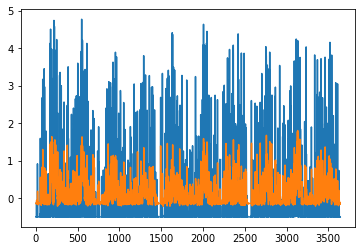

In [105]:
plt.plot(log_y_train)
plt.plot(log_train_pred) #20 layer만 batch size = 1 mini batch 20 0.98

# **Multivariate**

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
from scipy import stats

In [80]:
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/찐최종 데이터/구글클라우드플랫폼/seoul_final.csv',
                     encoding = 'UTF-8')
data2 = data2[['date', 'ca', 'avg_ta', 'new_wd', 'new_ws', 'sum_rn']]
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3957 non-null   object 
 1   ca      3957 non-null   float64
 2   avg_ta  3957 non-null   float64
 3   new_wd  3957 non-null   float64
 4   new_ws  3957 non-null   float64
 5   sum_rn  3957 non-null   float64
dtypes: float64(5), object(1)
memory usage: 185.6+ KB


             ca  avg_ta    new_wd  new_ws  sum_rn
date                                             
2012-01-01  5.1    -2.7 -606.6210 -9.6589     0.0
2012-01-02  2.9    -4.6 -501.4768 -5.1131     0.0
2012-01-03  7.5    -4.3 -607.3124 -7.7681     0.0
2012-01-04  1.1    -6.8 -613.9938 -7.9552     0.0
2012-01-05  0.0    -5.2 -581.0362 -5.4605     0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f06e8c55850>,
      dtype=object)

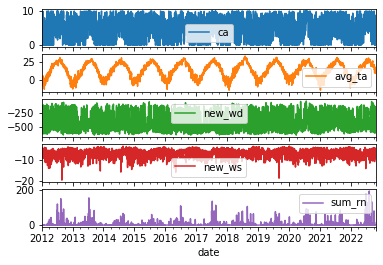

In [81]:
data2['date'] = pd.to_datetime(data2['date'])
data2 = data2.set_index('date')
print(data2.head())
data2.plot(subplots = True)

In [82]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [83]:
values = data2.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[0,1,2,3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var1(t)   var2(t)  \
1       0.51   0.242171   0.049197   0.606416        0.0     0.29  0.202505   
2       0.29   0.202505   0.230120   0.881624        0.0     0.75  0.208768   
3       0.75   0.208768   0.048007   0.720887        0.0     0.11  0.156576   
4       0.11   0.156576   0.036510   0.709560        0.0     0.00  0.189979   
5       0.00   0.189979   0.093221   0.860592        0.0     0.31  0.242171   

    var3(t)   var4(t)  var5(t)  
1  0.230120  0.881624      0.0  
2  0.048007  0.720887      0.0  
3  0.036510  0.709560      0.0  
4  0.093221  0.860592      0.0  
5  0.072354  0.839288      0.0  


In [85]:
#train test split
split_date = 3653
#split_date2 = pd.Timestamp('2019-12-31')

train = values[:split_date, :]
test = values[split_date:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3653, 1, 4) (3653,) (304, 1, 4) (304,)


In [86]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras import optimizers

K.clear_session()

model = Sequential()

#뉴런 50개 lstm model
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1],train_X.shape[2])))

model.add(LSTM(50, return_sequences=False, input_shape=(train_X.shape[1],train_X.shape[2])))
#model.add(LSTM(64, return_sequences=True, input_shape=(50,1)))

#model.add(LSTM(20, return_sequences=False, input_shape=(20,1))) # (timestep, feature)

#model.add(LSTM(20, return_sequences=False, input_shape=(10,1))) # (timestep, feature)

model.add(Dense(1)) # output = 1

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mae', optimizer=adam)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             11000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,251
Trainable params: 31,251
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
366/366 [==============================] - 8s 8ms/step - loss: 3.1899 - val_loss: 5.5974
Epoch 2/200
366/366 [==============================] - 2s 5ms/step - loss: 3.1874 - val_loss: 5.5965
Epoch 3/200
366/366 [==============================] - 2s 5ms/step - loss: 3.1859 - val_loss: 5.5932
Epoch 4/200
366/366 [==============================] - 2s 5ms/step - loss: 3.1818 - val_loss: 5.5889
Epoch 5/200
366/366 [==============================] - 2s 5ms/step - loss: 3.1781 - val_loss: 5.5865
Epoch 6/200
366/366 [==============================] - 2s 5ms/step - loss: 3.1738 - val_loss: 5.5888
Epoch 7/200
366/366 [==============================] - 2s 5ms/step - loss: 3.1696 - val_loss: 5.5853
Epoch 8/200
366/366 [==============================] - 2s 6ms/step - loss: 3.1659 - val_loss: 5.5827
Epoch 9/200
366/366 [==============================] - 2s 5ms/step - loss: 3.1623 - val_loss: 5.5834
Epoch 10/200
366/366 [==============================] - 2s 6ms/step - loss: 3.1585 - val_lo

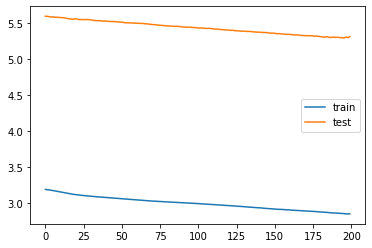

In [87]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = model.fit(train_X, train_y, epochs=200, batch_size = 10,
                    validation_data=(test_X, test_y), verbose=1, shuffle=False,
                    callbacks = [early_stop])
# plot history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [92]:
train_pred = model.predict(train_y)

InvalidArgumentError: ignored

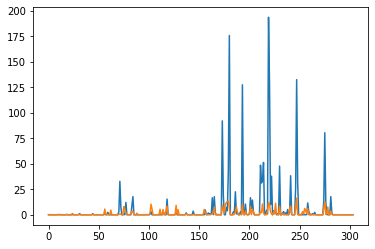

In [95]:
plt.plot(test_y)
plt.plot(yhat)

In [88]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenatet((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

10/10 [==============================] - 1s 4ms/step


ValueError: ignored

In [ ]:
print(X_test_t)

[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.01688653]
  [0.        ]
  [0.        ]]

 [[0.00388461]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.01688653]
  [0.        ]]

 [[0.        ]
  [0.00388461]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.01688653]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.00388461]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.00388461]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.00388461]]]


In [ ]:
train_pred = model.predict(X_train_t)
test_pred = model.predict(X_test_t)

# invert predictions
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform(y_train)
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test)

10/10 [==============================] - 0s 7ms/step


In [ ]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(y_train, train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, test_pred))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.98 RMSE
Test Score: 1.06 RMSE


In [ ]:
y_train

array([[-0.43194662],
       [-0.50159814],
       [-0.50159814],
       ...,
       [-0.49442021],
       [-0.50159814],
       [-0.50159814]])

In [ ]:
train_pred

array([[-0.16151644],
       [-0.17701435],
       [-0.18791623],
       ...,
       [-0.1428815 ],
       [-0.1451811 ],
       [-0.15089315]], dtype=float32)

In [ ]:
plt.plot(y_train)
plt.plot(train_pred) #50, 64 layer 추가 batch 1 mini batch 20 train score 0.99 

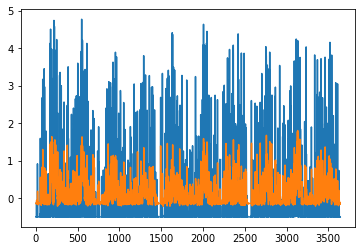

In [ ]:
plt.plot(y_train)
plt.plot(train_pred) #20 layer만 batch size = 1 mini batch 20 0.98